In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import *

In [67]:
# Load in the group data
traindf = pd.read_csv("../Clean/hourGroup18train.csv")
testdf = pd.read_csv("../Clean/hourGroup18test.csv")
futuredf = pd.read_csv("../Clean/hourGroup19.csv")

<AxesSubplot:>

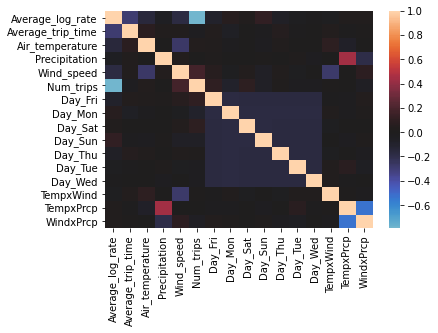

In [25]:
# Correlation visuals.
hourstrings = ["hour_only_" + str(i) for i in range(24)]
daystrings = ["Day_" + day for day in ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]]
corr = traindf.drop(hourstrings, axis = 1).corr()
sns.heatmap(data = corr, cmap = "icefire", center = 0)

<AxesSubplot:>

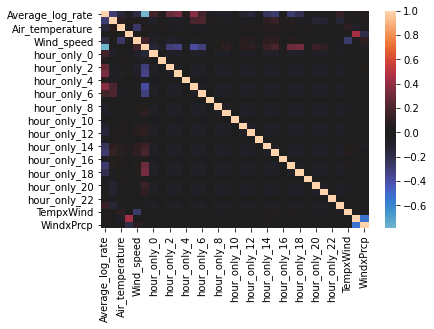

In [27]:
corr = traindf.drop(daystrings, axis = 1).corr()
sns.heatmap(data = corr, cmap = "icefire", center = 0)

In [62]:
# Remove unnecessary columns, OHE 2019
traindf = traindf.drop(["Average_trip_time", "Num_trips"], axis = 1)
testdf = testdf.drop(["Average_trip_time", "Num_trips"], axis = 1)
futuredf = futuredf.drop(["Average_trip_time", "Num_trips"], axis = 1)
futuredf = pd.get_dummies(futuredf, columns = ["hour_only", "Day"])

In [63]:
# Split into input and output subsets.
X_train = traindf.drop("Average_log_rate", axis = 1)
X_test = testdf.drop("Average_log_rate", axis = 1)
X_future = futuredf.drop("Average_log_rate", axis = 1)
y_train = traindf["Average_log_rate"]
y_test = testdf["Average_log_rate"]
y_future = futuredf["Average_log_rate"]

In [11]:
# Linear regression
all_columns = "+".join(X_train.columns)
formulastr = "Average_log_rate~" + all_columns
fit = ols(formula=formulastr, data = traindf).fit()
LinPreds = fit.predict(X_test)
LinFuture = fit.predict(X_future)
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:       Average_log_rate   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     281.0
Date:                Sat, 14 Aug 2021   Prob (F-statistic):               0.00
Time:                        16:58:43   Log-Likelihood:                 9113.6
No. Observations:                4281   AIC:                        -1.816e+04
Df Residuals:                    4245   BIC:                        -1.793e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.4986      0.002    8

<AxesSubplot:ylabel='Frequency'>

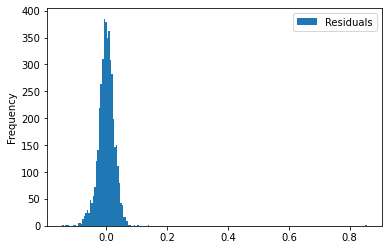

In [45]:
# Plot residuals to test Normally distributed error assumption.

residuals = fit.predict(X_train) - y_train
resdf = pd.DataFrame()
resdf["Residuals"] = residuals
resdf.plot.hist(bins = 200)

In [12]:
# LASSO

from glmnet import ElasticNet

lasso_fit = ElasticNet()
lasso_fit.fit(X_train.values, y_train.values)
best_lambda = lasso_fit.lambda_best_[0]
print(f'Best lambda value for LASSO: {best_lambda}')
LassoPreds = lasso_fit.predict(X_test)
LassoFuture = lasso_fit.predict(X_future)

Best lambda value for LASSO: 0.002509166792386039


In [13]:
pd.DataFrame(index = ['Intercept'] + (list(X_train.columns)), 
             data= [lasso_fit.intercept_] + list(lasso_fit.coef_), 
             columns = ['Coefficient'])

,Coefficient
Intercept,1.768361
Air_temperature,-0.000621
Precipitation,0.000000
Wind_speed,-0.000028
Day_Fri,-0.004622
Day_Mon,0.001169
Day_Sat,0.000000
Day_Sun,0.008239
Day_Thu,-0.001279
Day_Tue,0.000000


In [14]:
# Get dummy model predictions (= training mean).

DummyPreds = [np.mean(y_train)] * len(y_test)
DummyFuture = [np.mean(y_train)] * len(y_future)

In [15]:
# Find an optimal decision tree regressor.

kfolds = 50
avg_scores = []
for depth in range(1, 31):
    regressor = DecisionTreeRegressor(random_state=1, max_depth = depth)
    validation_scores = cross_val_score(regressor, X_train, y_train, cv=kfolds)
    avg_score = np.mean(validation_scores)
    avg_scores.append(avg_score)
    print(f"Max depth: {depth}, score: {avg_score}")
best_score = max(avg_scores)
best_depth = avg_scores.index(best_score ) + 1
print(f"Best score of {best_score} with max depth of {best_depth}")
tree_regressor = DecisionTreeRegressor(random_state=1, max_depth = best_depth)
tree_regressor.fit(X_train, y_train)
TreePreds = tree_regressor.predict(X_test)
TreeFuture = tree_regressor.predict(X_future)

Max depth: 1, score: 0.1323810961696835
Max depth: 2, score: 0.26243435337319004
Max depth: 3, score: 0.3806866529051813
Max depth: 4, score: 0.4506661159037928
Max depth: 5, score: 0.5253110620145626
Max depth: 6, score: 0.45420318799318826
Max depth: 7, score: 0.5914709299337763
Max depth: 8, score: 0.5074756733602928
Max depth: 9, score: 0.5894184478307454
Max depth: 10, score: 0.5517227504561661
Max depth: 11, score: 0.5633384450604936
Max depth: 12, score: 0.5753858351886906
Max depth: 13, score: 0.6757448353961464
Max depth: 14, score: 0.5759521376569124
Max depth: 15, score: 0.678803574023132
Max depth: 16, score: 0.6107353971160718
Max depth: 17, score: 0.6144475895385159
Max depth: 18, score: 0.5468293239988435
Max depth: 19, score: 0.5473066898841086
Max depth: 20, score: 0.5462409051129639
Max depth: 21, score: 0.5891954057688342
Max depth: 22, score: 0.5784625874373542
Max depth: 23, score: 0.6311169664520679
Max depth: 24, score: 0.5177367410400534
Max depth: 25, score: 0.

In [16]:
# Find an optimal Random Forest Regressor.

kfolds = 50
avg_scores = []
for depth in range(1, 31):
    regressor = RandomForestRegressor(random_state=1, max_depth = depth)
    validation_scores = cross_val_score(regressor, X_train, y_train, cv=kfolds)
    avg_score = np.mean(validation_scores)
    avg_scores.append(avg_score)
    print(f"Max depth: {depth}, score: {avg_score}")
best_score = max(avg_scores)
best_depth = avg_scores.index(best_score ) + 1
print(f"Best score of {best_score} with max depth of {best_depth}")
forest_regressor = RandomForestRegressor(random_state=1, max_depth = best_depth)
forest_regressor.fit(X_train, y_train)
ForestPreds = forest_regressor.predict(X_test)
ForestFuture = forest_regressor.predict(X_future)

Max depth: 1, score: 0.13792841336736195
Max depth: 2, score: 0.2658951609959365
Max depth: 3, score: 0.3849303915975934
Max depth: 4, score: 0.48040354237925265
Max depth: 5, score: 0.5316856508070246
Max depth: 6, score: 0.5907494259835729
Max depth: 7, score: 0.6281862243152765
Max depth: 8, score: 0.6546355294574313
Max depth: 9, score: 0.690204894992556
Max depth: 10, score: 0.7127251577196535
Max depth: 11, score: 0.7303412684190725
Max depth: 12, score: 0.7446309890929945
Max depth: 13, score: 0.7605283713222271
Max depth: 14, score: 0.7621187439915729
Max depth: 15, score: 0.7693248965231498
Max depth: 16, score: 0.773202462245537
Max depth: 17, score: 0.7738569870303887
Max depth: 18, score: 0.7693299326687576
Max depth: 19, score: 0.7746363173845008
Max depth: 20, score: 0.7701287076473498
Max depth: 21, score: 0.7793419476532947
Max depth: 22, score: 0.7770356815148621
Max depth: 23, score: 0.7670899708034551
Max depth: 24, score: 0.7719870450237997
Max depth: 25, score: 0.7

<AxesSubplot:xlabel='Log(fare/hr)'>

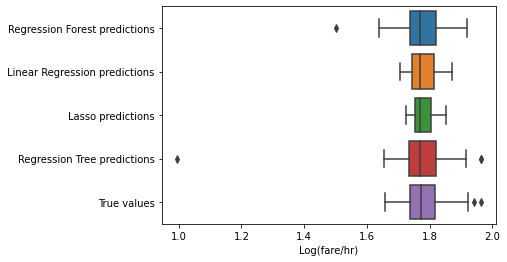

In [22]:
# Plot prediction distributions

predDF = pd.DataFrame()
predDF["Regression Forest predictions"] = ForestPreds
predDF["Linear Regression predictions"] = LinPreds
predDF["Lasso predictions"] = LassoPreds
predDF["Regression Tree predictions"] = TreePreds
predDF["True values"] = y_test
plot = sns.boxplot(data=predDF, orient = 'h')
plot.set_xlabel("Log(fare/hr)")
plot

<AxesSubplot:ylabel='Mean Squared Error (MSE)'>

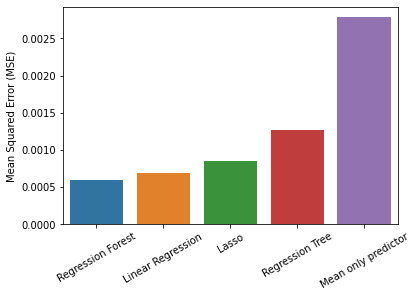

In [18]:
# Plot Mean Squared Errors (MSE).

LRMSE = mean_squared_error(LinPreds, y_test)
LasMSE = mean_squared_error(LassoPreds, y_test)
RTMSE = mean_squared_error(TreePreds, y_test)
RFMSE = mean_squared_error(ForestPreds, y_test)
DmyMSE = mean_squared_error(DummyPreds, y_test)
MSEdf = pd.DataFrame()
MSEdf["Linear Regression"] = [LRMSE]
MSEdf["Lasso"] = [LasMSE]
MSEdf["Regression Tree"] = [RTMSE]
MSEdf["Regression Forest"] = [RFMSE]
MSEdf["Mean only predictor"] = [DmyMSE]
MSEdf = MSEdf.sort_values(by = 0, axis = 1)
plot = sns.barplot(data=MSEdf)
plot.set_ylabel("Mean Squared Error (MSE)")
plot.set_xticklabels(plot.get_xticklabels(), rotation=30)
plot

<AxesSubplot:xlabel='Log(fare/hr)'>

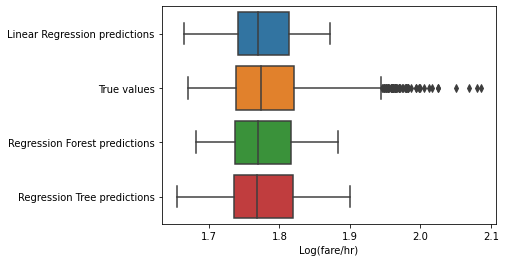

In [47]:
# Plot 2019 prediction distributions.

futurevals = pd.DataFrame()
futurevals["Linear Regression predictions"] = LinFuture
futurevals["True values"] = y_future
futurevalsF["Lasso predictions"] = LassoFuture
futurevals["Regression Forest predictions"] = ForestFuture
futurevals["Regression Tree predictions"] = TreeFuture
plot = sns.boxplot(data=futurevals, orient = 'h')
plot.set_xlabel("Log(fare/hr)")
plot

<AxesSubplot:ylabel='Mean Squared Error (MSE)'>

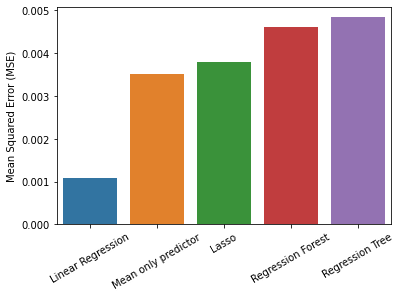

In [20]:
# Plot 2019 MSEs.

LRMSEFuture = mean_squared_error(LinFuture, y_future)
LasMSEFuture = mean_squared_error(LassoFuture, y_future)
RTMSEFuture = mean_squared_error(TreeFuture, y_future)
RFMSEFuture = mean_squared_error(ForestFuture, y_future)
DmyMSEFuture = mean_squared_error(DummyFuture, y_future)
MSEFuture = pd.DataFrame()
MSEFuture["Linear Regression"] = [LRMSEFuture]
MSEFuture["Lasso"] = [LasMSEFuture]
MSEFuture["Regression Tree"] = [RTMSEFuture]
MSEFuture["Regression Forest"] = [RFMSEFuture]
MSEFuture["Mean only predictor"] = [DmyMSEFuture]
MSEFuture = MSEFuture.sort_values(by = 0, axis = 1)
plot = sns.barplot(data=MSEFuture)
plot.set_ylabel("Mean Squared Error (MSE)")
plot.set_xticklabels(plot.get_xticklabels(), rotation=30)
plot

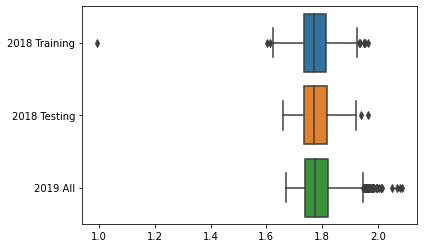

In [21]:
# Compare true distributions.

truedf = pd.DataFrame()
truedf["2018 Training"] = y_train
truedf["2018 Testing"] = y_test
truedf["2019 All"] = y_future
plot = sns.boxplot(data = truedf, orient = 'h')

<AxesSubplot:>

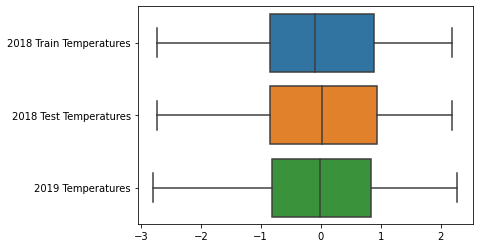

In [73]:
tempsdf = pd.DataFrame()
winddf = pd.DataFrame()
prcpdf = pd.DataFrame()
tempsdf["2018 Train Temperatures"] = traindf["Air_temperature"]
tempsdf["2018 Test Temperatures"] = testdf["Air_temperature"]
tempsdf["2019 Temperatures"] = futuredf["Air_temperature"]
winddf["2018 Train Wind Speeds"] = traindf["Wind_speed"]
winddf["2018 Test Wind Speeds"] = testdf["Wind_speed"]
winddf["2019 Wind Speeds"] = futuredf["Wind_speed"]
prcpdf["2018 Train Precipitation"] = traindf["Precipitation"]
prcpdf["2018 Test Precipitation"] = testdf["Precipitation"]
prcpdf["2019 Precipitation"] = futuredf["Precipitation"]
sns.boxplot(data = tempsdf, orient = 'h')

<AxesSubplot:>

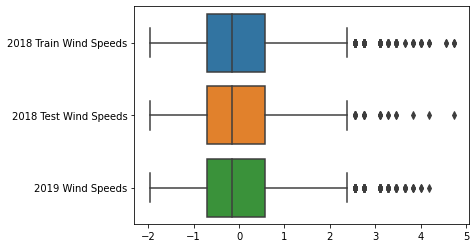

In [74]:
sns.boxplot(data = winddf, orient = 'h')

<AxesSubplot:>

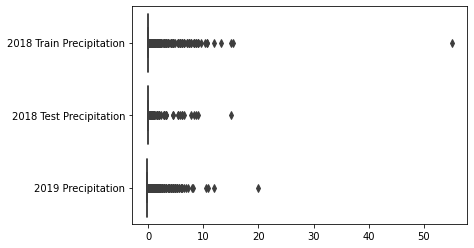

In [75]:
sns.boxplot(data = prcpdf, orient = 'h')